# Predicting Ticket Sales
*(Data accessed from [Zindi Africa](https://zindi.africa/))*

![BUS_TICKET](bus_ticket.jfif)

In [ ]:
# Insert missing libraries
!pip install holidays
!pip install lightgbm
!pip install xgboost
!pip install catboost

In [2]:
# Import libraries
import pandas as pd
import holidays
from datetime import timedelta
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LinearRegression, SGDRegressor, ElasticNet, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor

In [35]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [38]:
# Read training data
train_df = pd.read_csv("train_revised.csv")
train_df.head()

,ride_id,seat_number,payment_method,payment_receipt,travel_date,travel_time,travel_from,travel_to,car_type,max_capacity
0,1442,15A,Mpesa,UZUEHCBUSO,17-10-17,7:15,Migori,Nairobi,Bus,49
1,5437,14A,Mpesa,TIHLBUSGTE,19-11-17,7:12,Migori,Nairobi,Bus,49
2,5710,8B,Mpesa,EQX8Q5G19O,26-11-17,7:05,Keroka,Nairobi,Bus,49
3,5777,19A,Mpesa,SGP18CL0ME,27-11-17,7:10,Homa Bay,Nairobi,Bus,49
4,5778,11A,Mpesa,BM97HFRGL9,27-11-17,7:12,Migori,Nairobi,Bus,49


In [5]:
# Read testing data
test_df = pd.read_csv("test_questions.csv")
test_df.head()

,ride_id,travel_date,travel_time,travel_from,travel_to,car_type,max_capacity
0,247,2018-05-07,07:06,Kisii,Nairobi,Bus,49
1,256,2018-05-06,11:08,Kisii,Nairobi,shuttle,11
2,275,2018-05-04,05:00,Kisii,Nairobi,shuttle,11
3,285,2018-05-04,09:10,Kisii,Nairobi,shuttle,11
4,286,2018-05-04,09:20,Kisii,Nairobi,shuttle,11


## Data Exploration & Preprocessing

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51645 entries, 0 to 51644
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ride_id          51645 non-null  int64 
 1   seat_number      51645 non-null  object
 2   payment_method   51645 non-null  object
 3   payment_receipt  51645 non-null  object
 4   travel_date      51645 non-null  object
 5   travel_time      51645 non-null  object
 6   travel_from      51645 non-null  object
 7   travel_to        51645 non-null  object
 8   car_type         51645 non-null  object
 9   max_capacity     51645 non-null  int64 
dtypes: int64(2), object(8)
memory usage: 3.9+ MB


In [7]:
train_df.isnull().sum()

ride_id            0
seat_number        0
payment_method     0
payment_receipt    0
travel_date        0
travel_time        0
travel_from        0
travel_to          0
car_type           0
max_capacity       0
dtype: int64

In [8]:
# Reduce training data to features that are available to the predicting input
train_df = train_df[test_df.columns]

In [9]:
# Group tickets by the ride
grouped_df = pd.concat([train_df.groupby("ride_id").min(),train_df.groupby("ride_id").agg({"ride_id":"count"}).rename(columns={"ride_id":"count"})],axis=1, join="inner", sort=True)
grouped_df.head()

,travel_date,travel_time,travel_from,travel_to,car_type,max_capacity,count
ride_id,,,,,,,
1442,17-10-17,7:15,Migori,Nairobi,Bus,49,1
5437,19-11-17,7:12,Migori,Nairobi,Bus,49,1
5710,26-11-17,7:05,Keroka,Nairobi,Bus,49,1
5777,27-11-17,7:10,Homa Bay,Nairobi,Bus,49,5
5778,27-11-17,7:12,Migori,Nairobi,Bus,49,31


In [10]:
# Format the date and time columns
grouped_df.travel_date = pd.to_datetime(grouped_df.travel_date, format="%d-%m-%y")
grouped_df.travel_time = pd.to_datetime(grouped_df.travel_time, format="%H:%M")

In [11]:
grouped_df["travel_weekday"] = grouped_df.travel_date.dt.weekday
grouped_df.travel_weekday = grouped_df.travel_weekday.astype("category")
grouped_df.head()

,travel_date,travel_time,travel_from,travel_to,car_type,max_capacity,count,travel_weekday
ride_id,,,,,,,,
1442,2017-10-17,1900-01-01 07:15:00,Migori,Nairobi,Bus,49,1,1
5437,2017-11-19,1900-01-01 07:12:00,Migori,Nairobi,Bus,49,1,6
5710,2017-11-26,1900-01-01 07:05:00,Keroka,Nairobi,Bus,49,1,6
5777,2017-11-27,1900-01-01 07:10:00,Homa Bay,Nairobi,Bus,49,5,0
5778,2017-11-27,1900-01-01 07:12:00,Migori,Nairobi,Bus,49,31,0


In [12]:
def holiday_ref(date):
    kenya_holidays = holidays.Kenya()
    if date - timedelta(days = 1) in kenya_holidays:
        ref = "1-day-prior"
    elif date in kenya_holidays:
        ref = "holiday"
    elif date + timedelta(days = 1) in kenya_holidays:
        ref = "1-day-after"
    else:
        ref = "na"

    return ref

grouped_df["travel_public_holiday"] = grouped_df.travel_date.map(holiday_ref)
grouped_df.head()

,travel_date,travel_time,travel_from,travel_to,car_type,max_capacity,count,travel_weekday,travel_public_holiday
ride_id,,,,,,,,,
1442,2017-10-17,1900-01-01 07:15:00,Migori,Nairobi,Bus,49,1,1,na
5437,2017-11-19,1900-01-01 07:12:00,Migori,Nairobi,Bus,49,1,6,na
5710,2017-11-26,1900-01-01 07:05:00,Keroka,Nairobi,Bus,49,1,6,na
5777,2017-11-27,1900-01-01 07:10:00,Homa Bay,Nairobi,Bus,49,5,0,na
5778,2017-11-27,1900-01-01 07:12:00,Migori,Nairobi,Bus,49,31,0,na


In [13]:
grouped_df["travel_hours"] = grouped_df.travel_time.dt.hour
grouped_df.head()

,travel_date,travel_time,travel_from,travel_to,car_type,max_capacity,count,travel_weekday,travel_public_holiday,travel_hours
ride_id,,,,,,,,,,
1442,2017-10-17,1900-01-01 07:15:00,Migori,Nairobi,Bus,49,1,1,na,7
5437,2017-11-19,1900-01-01 07:12:00,Migori,Nairobi,Bus,49,1,6,na,7
5710,2017-11-26,1900-01-01 07:05:00,Keroka,Nairobi,Bus,49,1,6,na,7
5777,2017-11-27,1900-01-01 07:10:00,Homa Bay,Nairobi,Bus,49,5,0,na,7
5778,2017-11-27,1900-01-01 07:12:00,Migori,Nairobi,Bus,49,31,0,na,7


In [14]:
grouped_df.drop(columns=["travel_date","travel_time","travel_to"], axis=1, inplace=True)
grouped_df.head()

,travel_from,car_type,max_capacity,count,travel_weekday,travel_public_holiday,travel_hours
ride_id,,,,,,,
1442,Migori,Bus,49,1,1,na,7
5437,Migori,Bus,49,1,6,na,7
5710,Keroka,Bus,49,1,6,na,7
5777,Homa Bay,Bus,49,5,0,na,7
5778,Migori,Bus,49,31,0,na,7


In [15]:
grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6249 entries, 1442 to 20117
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   travel_from            6249 non-null   object  
 1   car_type               6249 non-null   object  
 2   max_capacity           6249 non-null   int64   
 3   count                  6249 non-null   int64   
 4   travel_weekday         6249 non-null   category
 5   travel_public_holiday  6249 non-null   object  
 6   travel_hours           6249 non-null   int32   
dtypes: category(1), int32(1), int64(2), object(3)
memory usage: 452.7+ KB


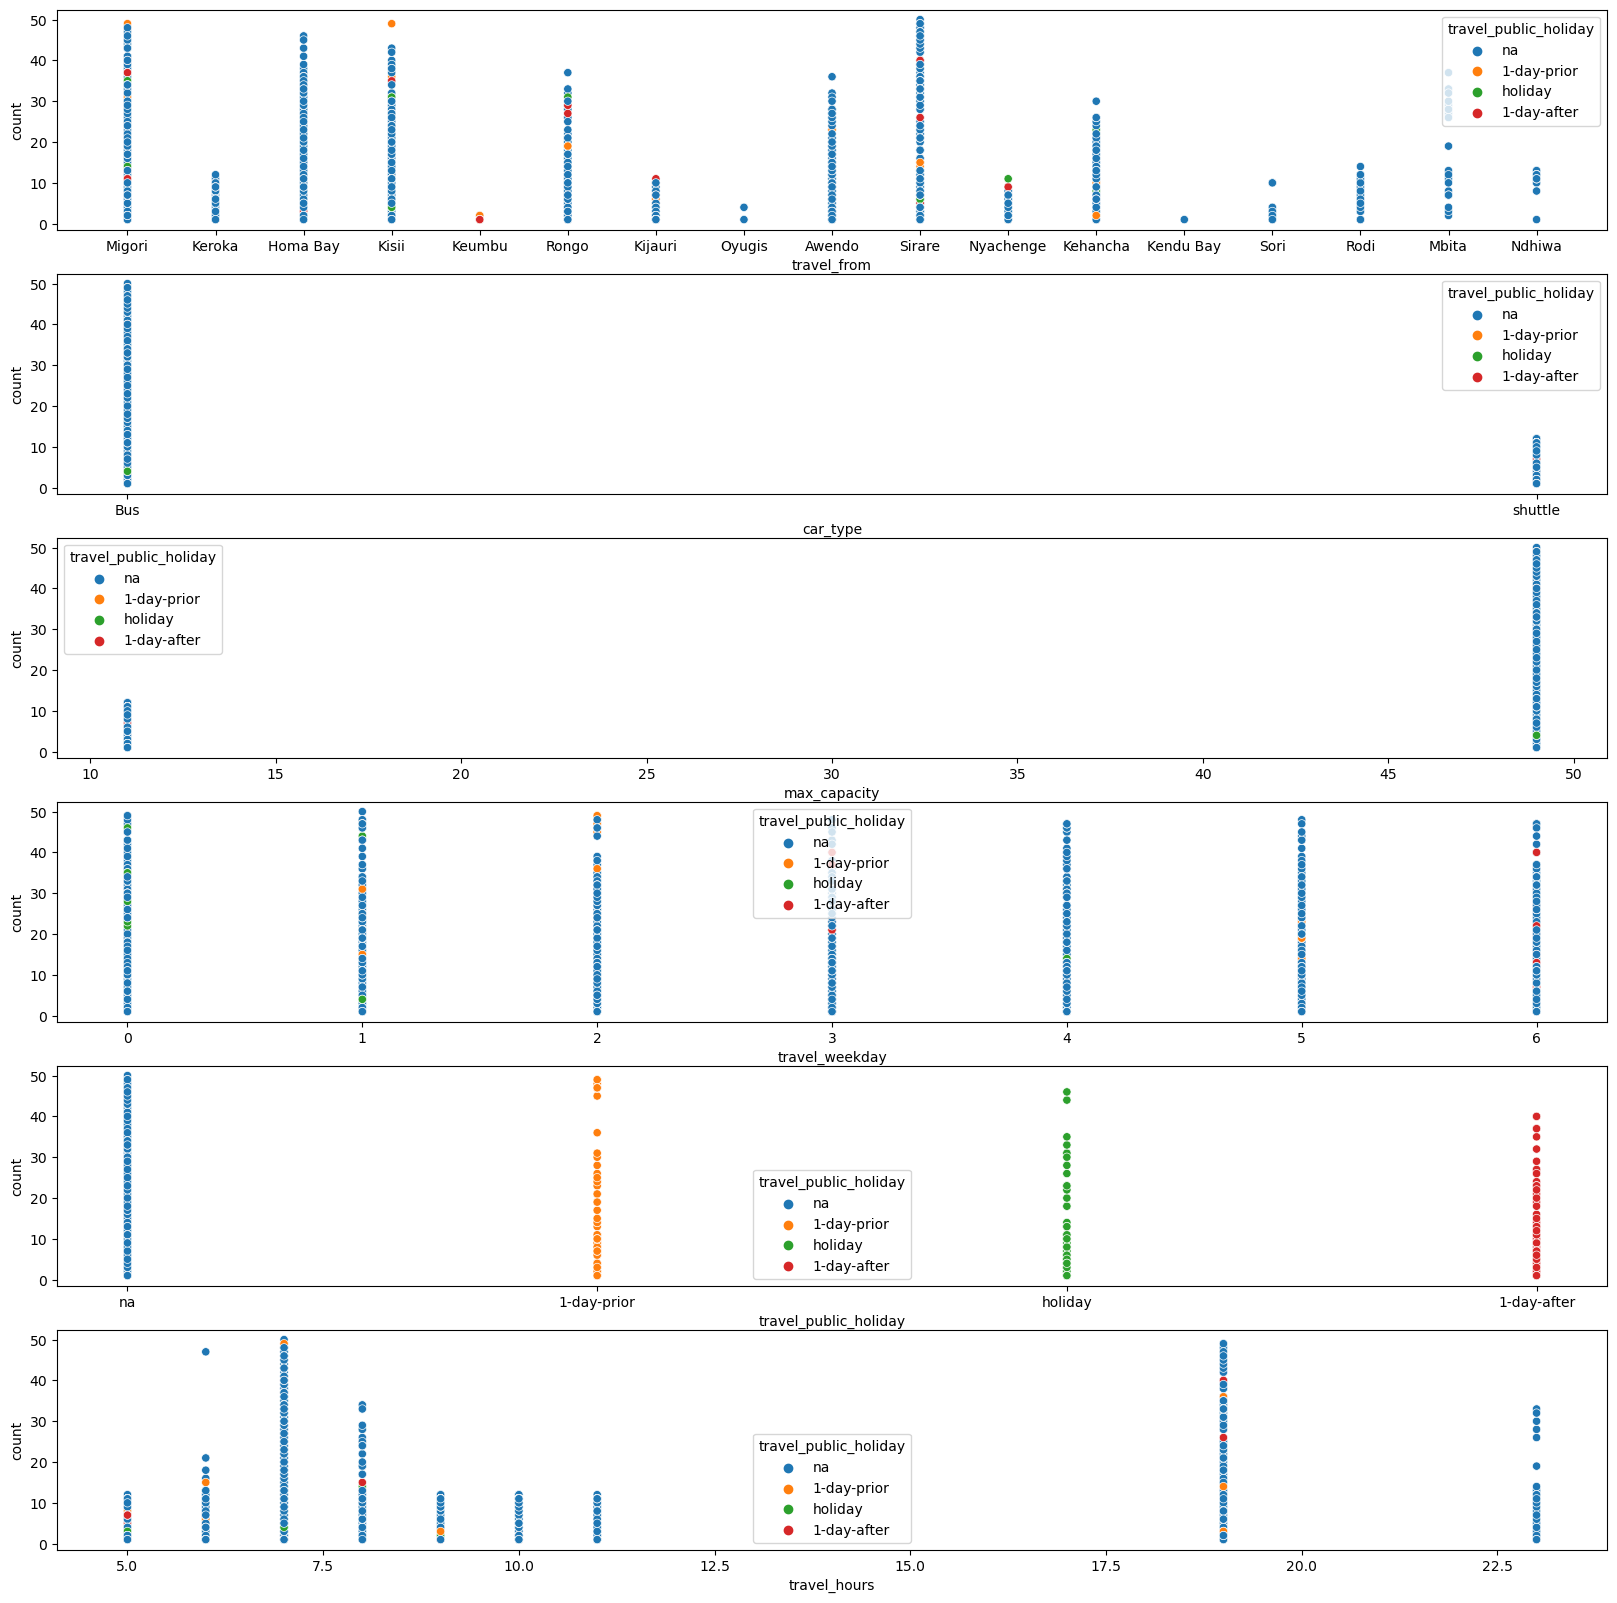

In [16]:
fig,ax = plt.subplots(len(grouped_df.drop(columns="count").columns), 1, figsize = (20,20))

for i in range(len(grouped_df.drop(columns="count").columns)):
    sns.scatterplot(grouped_df, x=grouped_df.drop(columns="count").columns[i], y="count",ax=ax[i], hue="travel_public_holiday")

plt.show()

In [17]:
processed_train_df = pd.get_dummies(grouped_df, drop_first=True, dtype=int)
processed_train_df.head()

,max_capacity,count,travel_hours,travel_from_Homa Bay,travel_from_Kehancha,travel_from_Kendu Bay,travel_from_Keroka,travel_from_Keumbu,travel_from_Kijauri,travel_from_Kisii,...,car_type_shuttle,travel_weekday_1,travel_weekday_2,travel_weekday_3,travel_weekday_4,travel_weekday_5,travel_weekday_6,travel_public_holiday_1-day-prior,travel_public_holiday_holiday,travel_public_holiday_na
ride_id,,,,,,,,,,,,,,,,,,,,,
1442,49,1,7,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
5437,49,1,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
5710,49,1,7,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
5777,49,5,7,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5778,49,31,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [18]:
processed_train_df[grouped_df.drop(columns="count").select_dtypes(include=[int]).columns]

,max_capacity,travel_hours
ride_id,,
1442,49,7
5437,49,7
5710,49,7
5777,49,7
5778,49,7
...,...,...
20113,11,7
20114,49,7
20115,11,7


In [19]:
processed_train_df[grouped_df.drop(columns="count").select_dtypes(include=[int]).columns] = StandardScaler().fit_transform(processed_train_df.drop(columns="count")[grouped_df.drop(columns="count").select_dtypes(include=[int]).columns])
processed_train_df.head()

,max_capacity,count,travel_hours,travel_from_Homa Bay,travel_from_Kehancha,travel_from_Kendu Bay,travel_from_Keroka,travel_from_Keumbu,travel_from_Kijauri,travel_from_Kisii,...,car_type_shuttle,travel_weekday_1,travel_weekday_2,travel_weekday_3,travel_weekday_4,travel_weekday_5,travel_weekday_6,travel_public_holiday_1-day-prior,travel_public_holiday_holiday,travel_public_holiday_na
ride_id,,,,,,,,,,,,,,,,,,,,,
1442,0.979565,1,-0.322023,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
5437,0.979565,1,-0.322023,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
5710,0.979565,1,-0.322023,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
5777,0.979565,5,-0.322023,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5778,0.979565,31,-0.322023,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [20]:
X, y = processed_train_df.drop(columns=["count"]),processed_train_df["count"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4374, 28), (1875, 28), (4374,), (1875,))

## Modelling

In [22]:
algos = {
    "lnr": LinearRegression(),
    "lbr": LGBMRegressor(),
    "xgr": XGBRegressor(),
    "cbr": CatBoostRegressor(),
    "sdr": SGDRegressor(),
    "knr": KernelRidge(),
    "enr": ElasticNet(),
    "byr": BayesianRidge(),
    "gbr": GradientBoostingRegressor(),
    "svr": SVR()
}

scores= {}

def modeller(algo):
    reg = algo.fit(X_train, y_train)
    score = reg.score(X_test, y_test)
    return score

In [23]:
for algo in algos:
    scores[algo] = modeller(algos[algo])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 53
[LightGBM] [Info] Number of data points in the train set: 4374, number of used features: 22
[LightGBM] [Info] Start training from score 8.227938
Learning rate set to 0.051694
0:	learn: 8.4417253	total: 157ms	remaining: 2m 37s
1:	learn: 8.2961806	total: 160ms	remaining: 1m 19s
2:	learn: 8.1627764	total: 163ms	remaining: 54.3s
3:	learn: 8.0447619	total: 166ms	remaining: 41.4s
4:	learn: 7.9322991	total: 170ms	remaining: 33.7s
5:	learn: 7.8266647	total: 173ms	remaining: 28.6s
6:	learn: 7.7231906	total: 176ms	remaining: 24.9s
7:	learn: 7.6294323	total: 179ms	remaining: 22.1s
8:	learn: 7.5464744	total: 181ms	remaining: 19.9s
9:	learn: 7.4752122	total: 183ms	re

In [24]:
scores

{'lnr': 0.36467441707889625,
 'lbr': 0.392551039289753,
 'xgr': 0.37246024499304453,
 'cbr': 0.3809552393528822,
 'sdr': 0.36496613409590484,
 'knr': 0.3649991411470448,
 'enr': 0.07106025771251501,
 'byr': 0.3652432030619257,
 'gbr': 0.41428958552817097,
 'svr': 0.3235390788195257}

In [25]:
selected_algo,selected_algo_score = max(scores.items(), key=lambda e: e[1])

print(f"Selected Estimator: {selected_algo}, Scored: {selected_algo_score}")

Selected Estimator: gbr, Scored: 0.41428958552817097


In [31]:
param_grid = {
    "learning_rate": np.arange(0.025, 0.2, 0.025),
    "min_samples_split": np.linspace(0.1, 0.9, 6),
    "min_samples_leaf": np.linspace(0.1, 0.9, 6),
    "max_depth":[2,3,5,8],
    "max_features":["log2","sqrt"],
    "subsample":np.linspace(0.5, 1.0,5),
    "n_estimators":np.arange(50, 151, 20)
    }

estimator = algos[selected_algo]
grid_search = RandomizedSearchCV(estimator = estimator, param_distributions = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_jobs=-1,
                   param_distributions={'learning_rate': array([0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175]),
                                        'max_depth': [2, 3, 5, 8],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': array([0.1 , 0.26, 0.42, 0.58, 0.74, 0.9 ]),
                                        'min_samples_split': array([0.1 , 0.26, 0.42, 0.58, 0.74, 0.9 ]),
                                        'n_estimators': array([ 50,  70,  90, 110, 130, 150]),
                                        'subsample': array([0.5  , 0.625, 0.75 , 0.875, 1.   ])},
                   verbose=2)

In [32]:
grid_search.best_estimator_,grid_search.best_score_,grid_search.best_params_

(GradientBoostingRegressor(learning_rate=0.07500000000000001, max_depth=2,
                           max_features='sqrt', min_samples_leaf=0.1,
                           min_samples_split=0.9, n_estimators=50),
 0.082765978229982,
 {'subsample': 1.0,
  'n_estimators': 50,
  'min_samples_split': 0.9,
  'min_samples_leaf': 0.1,
  'max_features': 'sqrt',
  'max_depth': 2,
  'learning_rate': 0.07500000000000001})

In [33]:
modeller(GradientBoostingRegressor(subsample= 1.0,
  n_estimators= 50,
  min_samples_split= 0.9,
  min_samples_leaf= 0.1,
  max_features= 'sqrt',
  max_depth= 2,
  learning_rate= 0.075))

0.07240581685575187

## Prediction